# Exploratory Data Analysis (Formatted Zone)
Complex Seasonality Analysis

In [1]:
from database_settings import postgres_utilities
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time_granularities_analysis import time_granularity_analysis
import time_granularities_generator

## Get the time series


In [2]:
# Establish the connection with the Persistent Zone
engine = postgres_utilities.engine()
# Filters
net_weight_threshold = 100
value_usd_threshold = 200
headings_count_threshold = 100
year_threshold = 2017
# Get all the data filtered
df = pd.DataFrame(postgres_utilities.run_query_file(engine,
                                           './queries/heading_data.sql',
                                           params={'year_threshold': year_threshold,
                                                   'headings_count_threshold': headings_count_threshold,
                                                   'value_usd_threshold': value_usd_threshold,
                                                   'net_weight_threshold': net_weight_threshold}))

Connected to Formatted Zone successfully!


In [3]:
# Select a random heading (optionally, select a exporter)
heading, description, exporter = df.sample()[['heading','description', 'exporter_id']].iloc[0]
print('Heading: {}, Description: {}'.format(heading,description))
heading_data = df[(df['heading']==heading)].copy()

Heading: 0805299000, Description: Otros agrios (cítricos) similares a mandarinas, clementinas o wikings, frescos o secos


In [4]:
# Generate the time granularities
start_date = heading_data['boarding_date'].min()
end_date = heading_data['boarding_date'].max()

time_granularities, granularity_priority = time_granularities_generator.generate(start_date,end_date)

### Daily kilogram's price time series

In [5]:
# usd/kg time series
heading_data['usd_kg'] = heading_data['value_usd']/heading_data['net_weight']
heading_data['usd_kg'] = heading_data['usd_kg'].astype(float)
heading_data['usd_kg'] = heading_data['usd_kg'].round(3)
# Group by boarding_date
usd_kg = heading_data[['boarding_date','usd_kg']].groupby(by=['boarding_date']).mean().round(3)
# Impute missing dates assigning the usd_kg of the day before
usd_kg.index = pd.to_datetime(usd_kg.index)
usd_kg = usd_kg.resample('D').ffill()
# Add the time granularities
usd_kg = pd.concat([usd_kg, time_granularities], axis=1)
usd_kg

,usd_kg,year,semester_in_year,quarter_in_year,month_in_year,month_in_semester,month_in_quarter,quarter_in_semester,day_in_year,day_in_semester,day_in_quarter,day_in_month,day_in_week,week_in_year,week_in_semester,week_in_quarter,week_in_month
2017-04-13,1.711,2017,1,2,4,4,1,2,103,103,13,13,4,15,15,2,2
2017-04-14,1.711,2017,1,2,4,4,1,2,104,104,14,14,5,15,15,2,2
2017-04-15,1.711,2017,1,2,4,4,1,2,105,105,15,15,6,15,15,2,2
2017-04-16,1.711,2017,1,2,4,4,1,2,106,106,16,16,7,15,15,2,2
2017-04-17,1.711,2017,1,2,4,4,1,2,107,107,17,17,1,16,16,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25,1.075,2023,1,2,4,4,1,2,115,115,25,25,2,17,17,4,4
2023-04-26,1.185,2023,1,2,4,4,1,2,116,116,26,26,3,17,17,4,4
2023-04-27,1.350,2023,1,2,4,4,1,2,117,117,27,27,4,17,17,4,4
2023-04-28,1.350,2023,1,2,4,4,1,2,118,118,28,28,5,17,17,4,4


### Daily total (net) weight exporter time series

In [6]:
# total net weight time series
# Group by boarding_date
net_weight = heading_data[['boarding_date','net_weight']].groupby(by=['boarding_date']).sum().round(3)
# Impute missing dates assigning 0 kg for days without shipments
net_weight.index = pd.to_datetime(net_weight.index)
net_weight = net_weight.resample('D').asfreq()
net_weight.fillna(0.0, inplace=True)
# Convert numerical columns to float
net_weight = net_weight.astype({'net_weight': 'float'})
# Add the time granularities
net_weight = pd.concat([net_weight, time_granularities], axis=1)
net_weight

,net_weight,year,semester_in_year,quarter_in_year,month_in_year,month_in_semester,month_in_quarter,quarter_in_semester,day_in_year,day_in_semester,day_in_quarter,day_in_month,day_in_week,week_in_year,week_in_semester,week_in_quarter,week_in_month
2017-04-13,45672.0,2017,1,2,4,4,1,2,103,103,13,13,4,15,15,2,2
2017-04-14,0.0,2017,1,2,4,4,1,2,104,104,14,14,5,15,15,2,2
2017-04-15,0.0,2017,1,2,4,4,1,2,105,105,15,15,6,15,15,2,2
2017-04-16,0.0,2017,1,2,4,4,1,2,106,106,16,16,7,15,15,2,2
2017-04-17,0.0,2017,1,2,4,4,1,2,107,107,17,17,1,16,16,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25,184096.0,2023,1,2,4,4,1,2,115,115,25,25,2,17,17,4,4
2023-04-26,327010.0,2023,1,2,4,4,1,2,116,116,26,26,3,17,17,4,4
2023-04-27,22540.0,2023,1,2,4,4,1,2,117,117,27,27,4,17,17,4,4
2023-04-28,0.0,2023,1,2,4,4,1,2,118,118,28,28,5,17,17,4,4


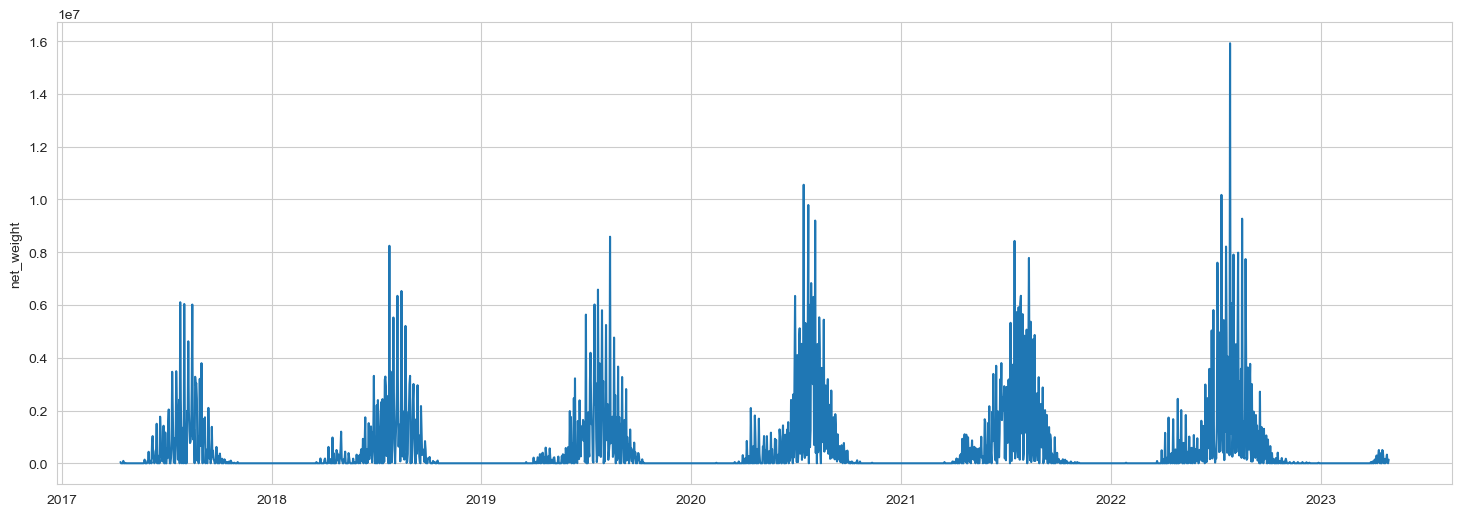

In [7]:
# Plot time series
plt.figure(figsize=(18,6))
sns.lineplot(x=net_weight.index, y="net_weight", data=net_weight)
plt.show()

  0%|          | 0/12 [00:00<?, ?it/s]

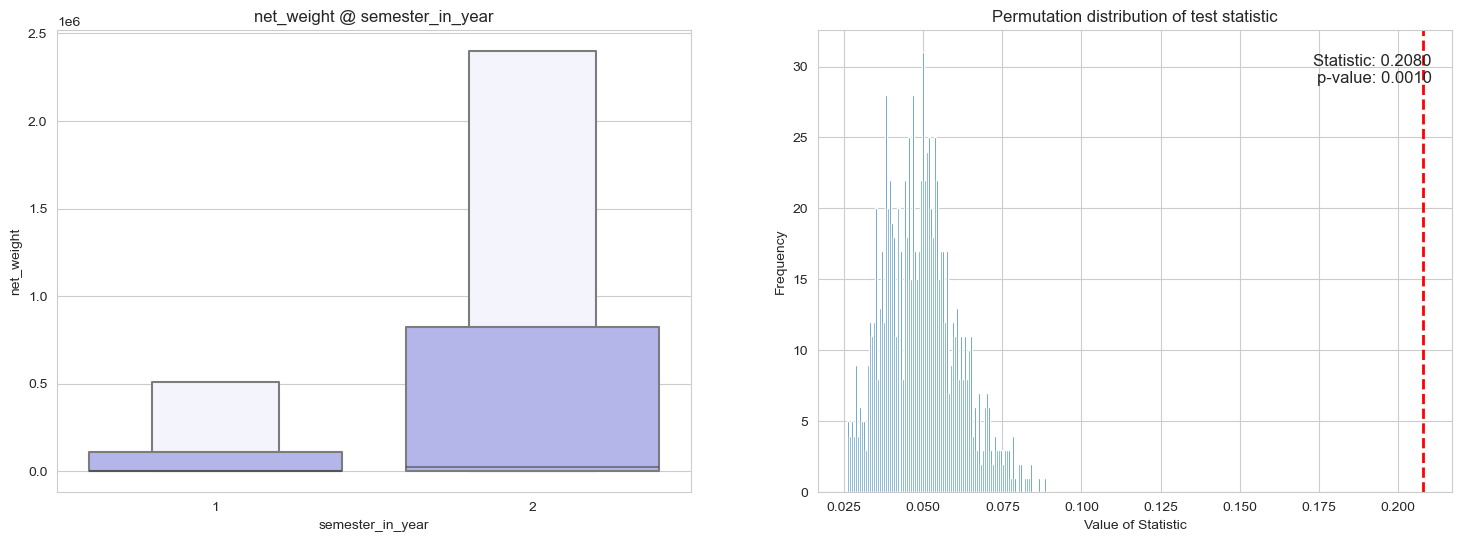

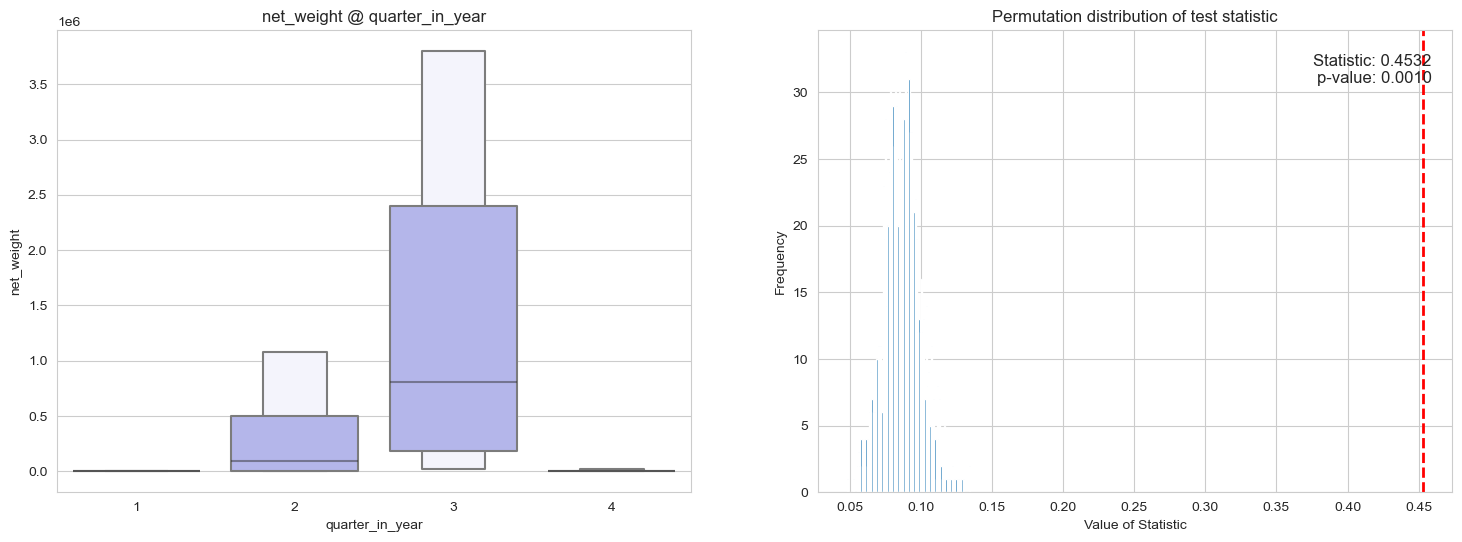

C:\Users\sergio\anaconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


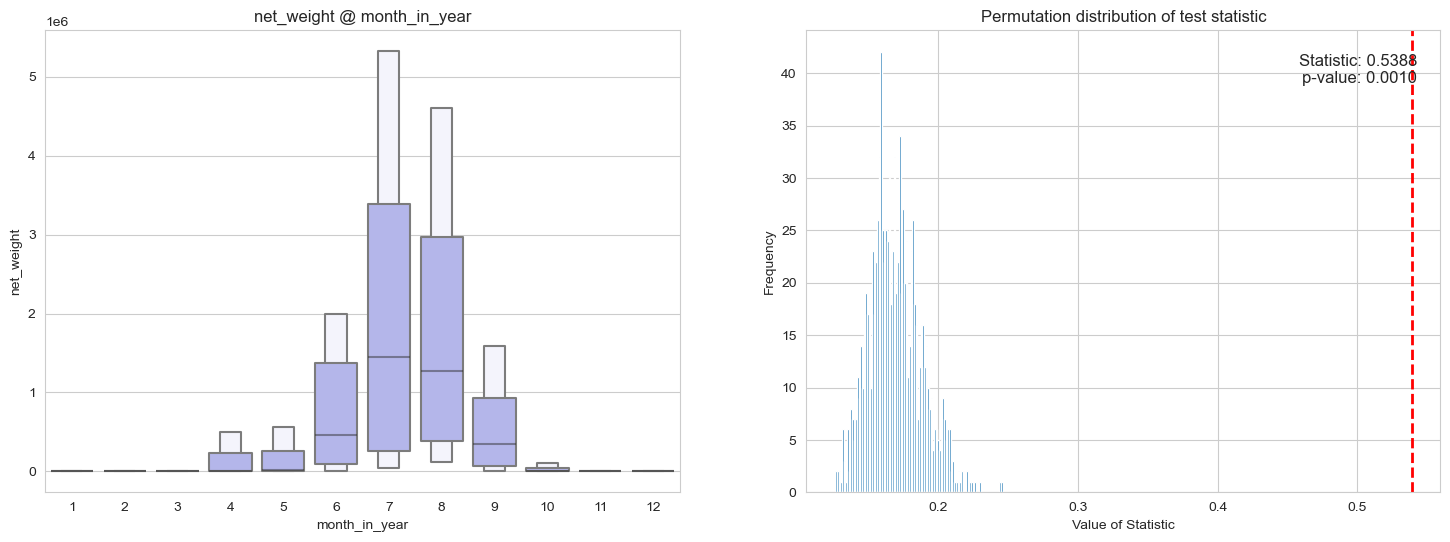

C:\Users\sergio\anaconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


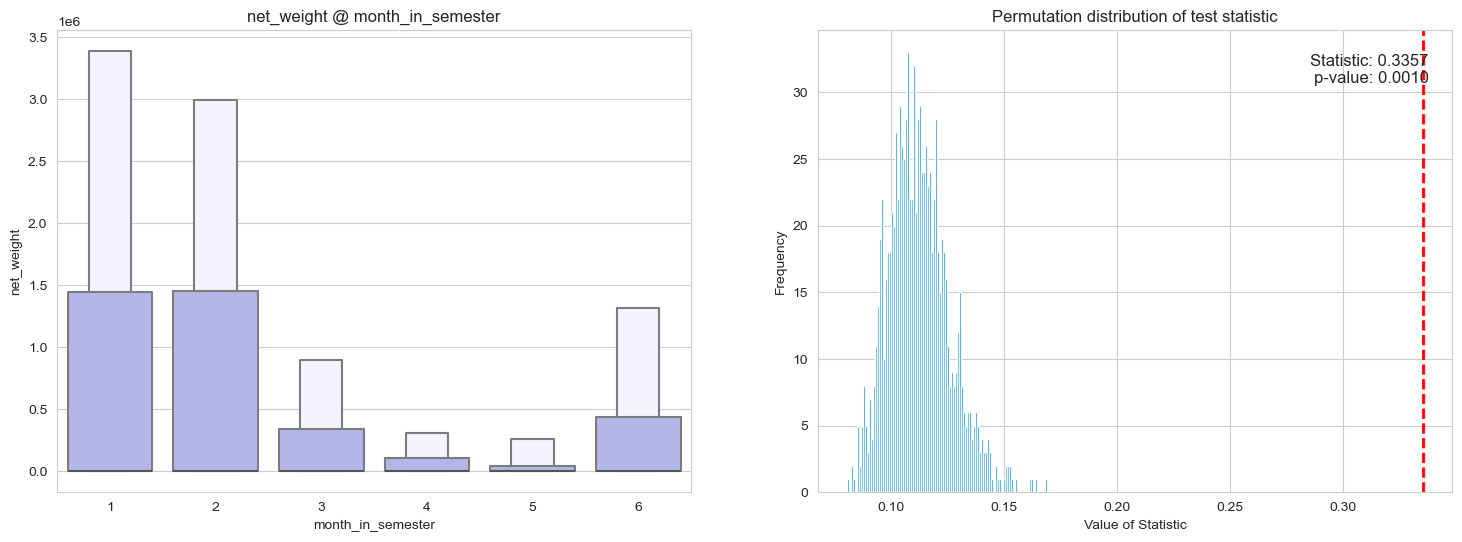

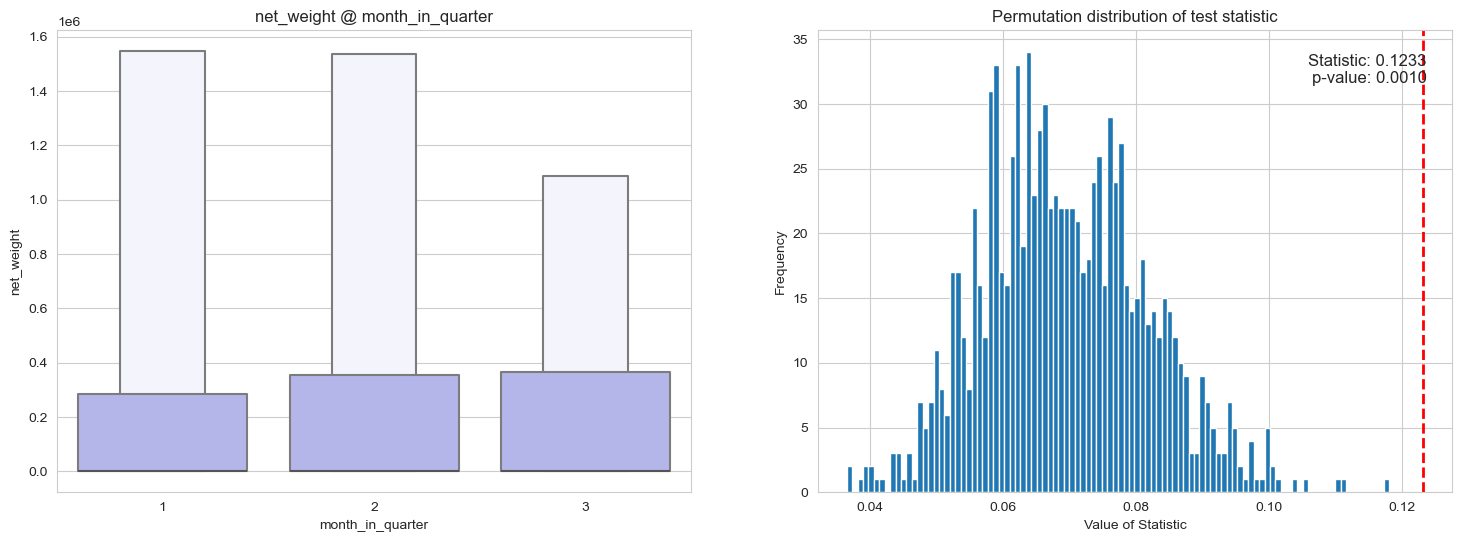

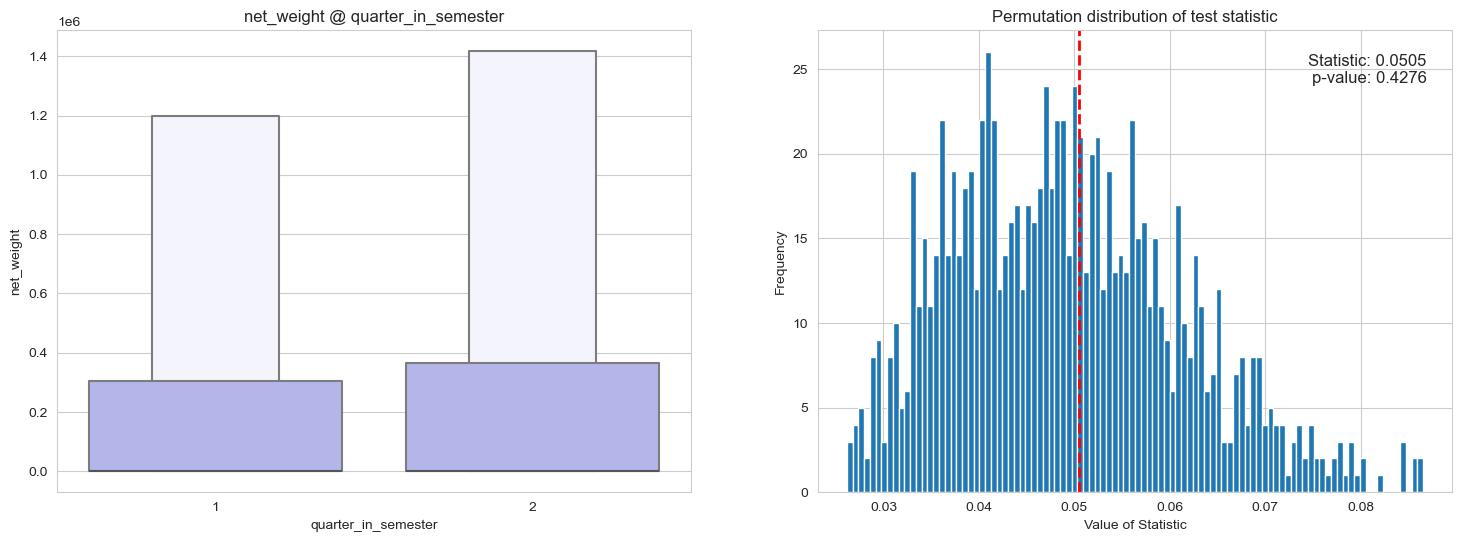

C:\Users\sergio\anaconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


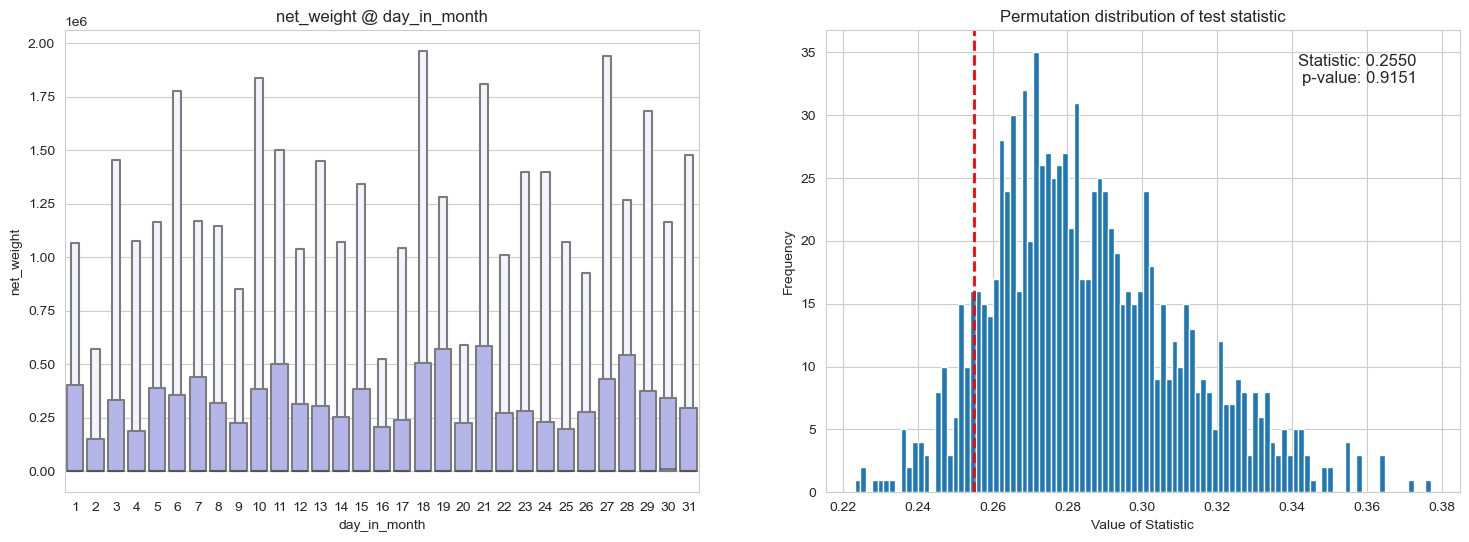

C:\Users\sergio\anaconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


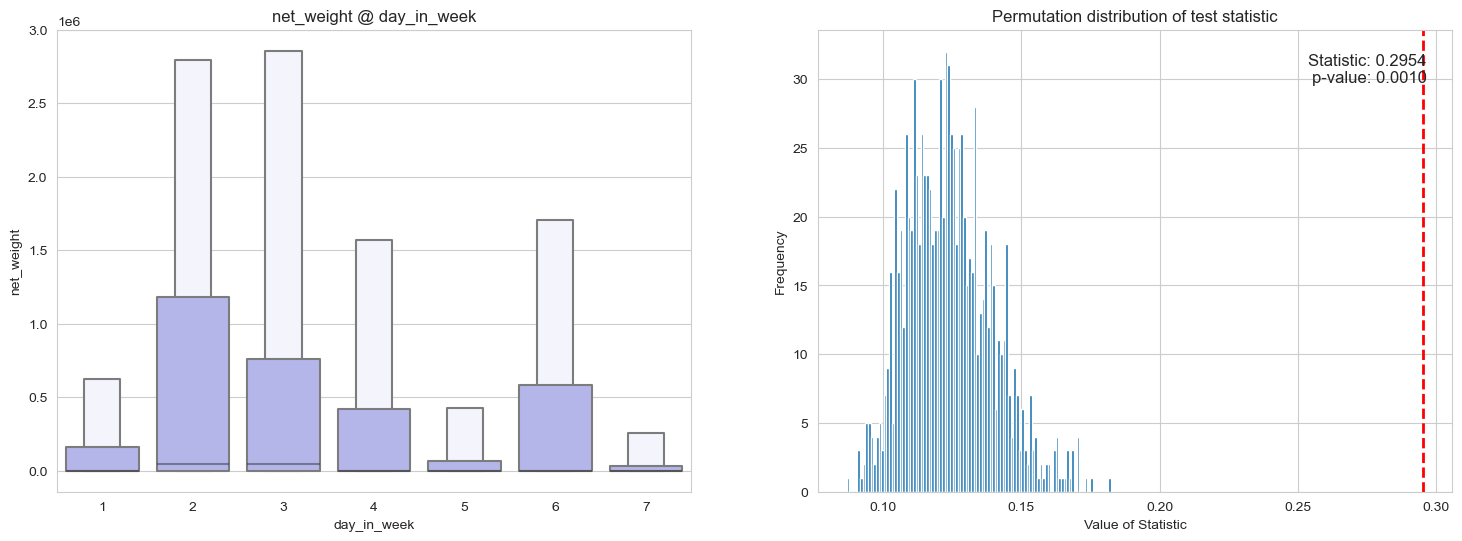

C:\Users\sergio\anaconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


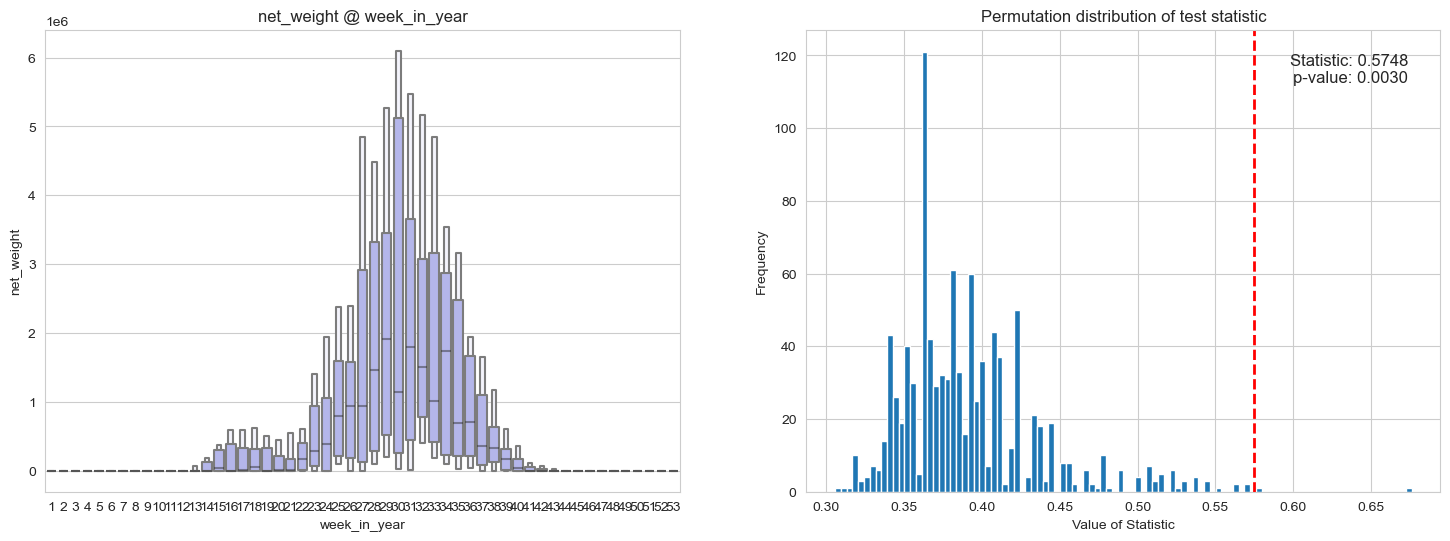

C:\Users\sergio\anaconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


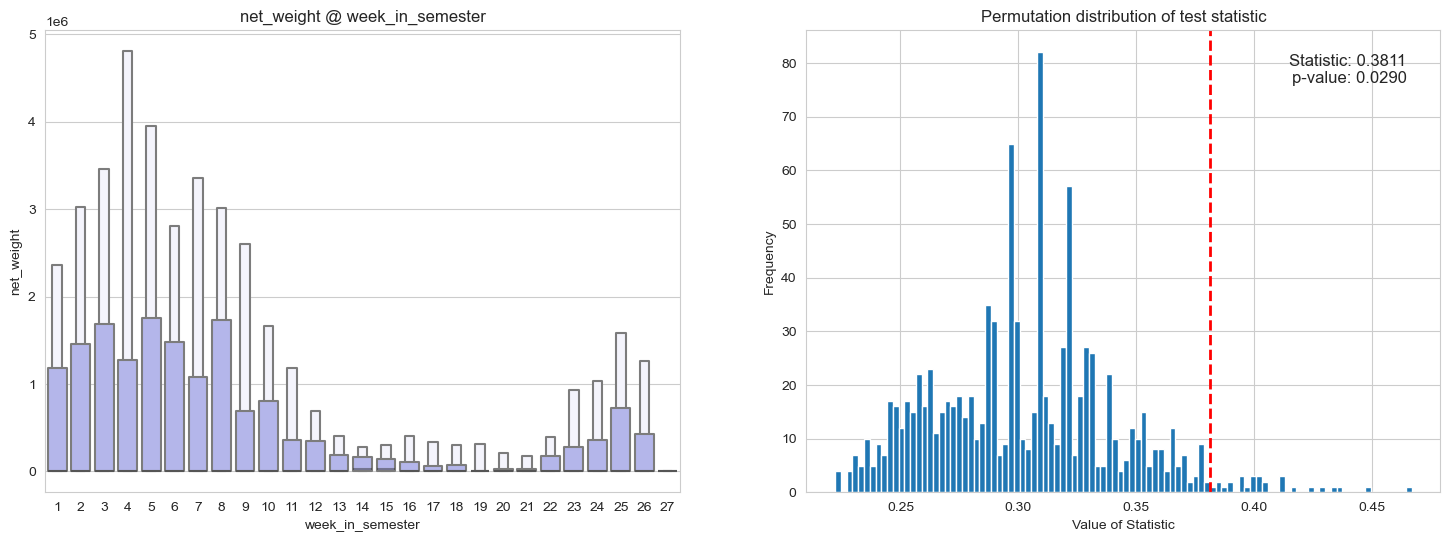

C:\Users\sergio\anaconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


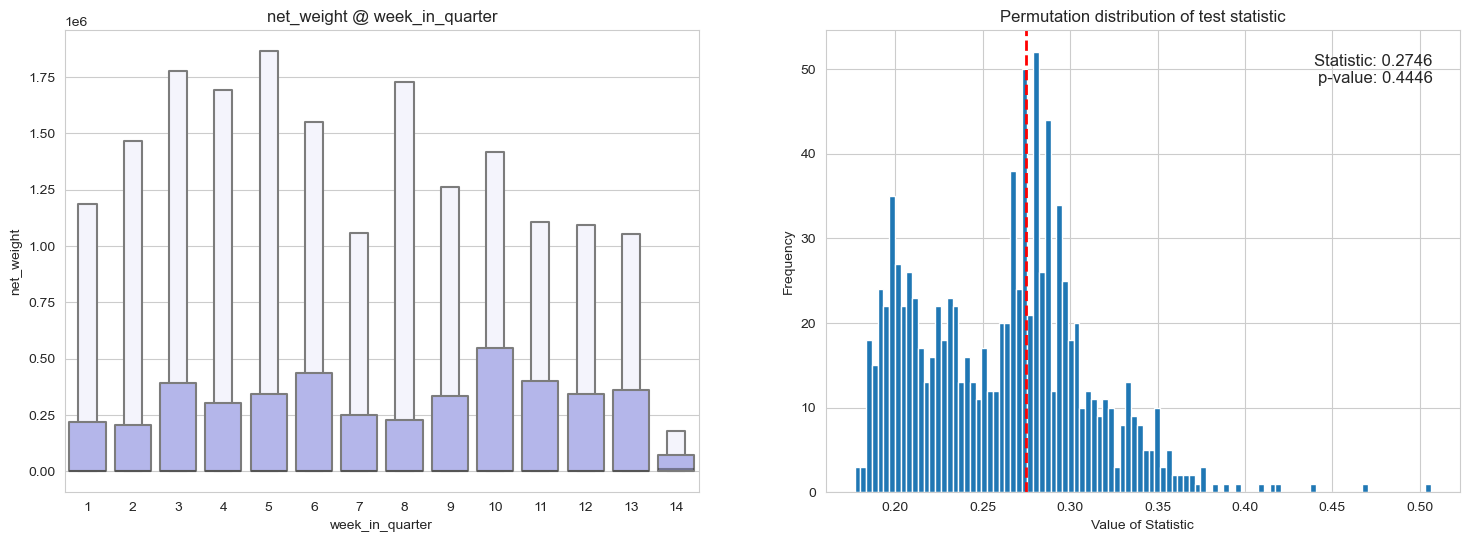

C:\Users\sergio\anaconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


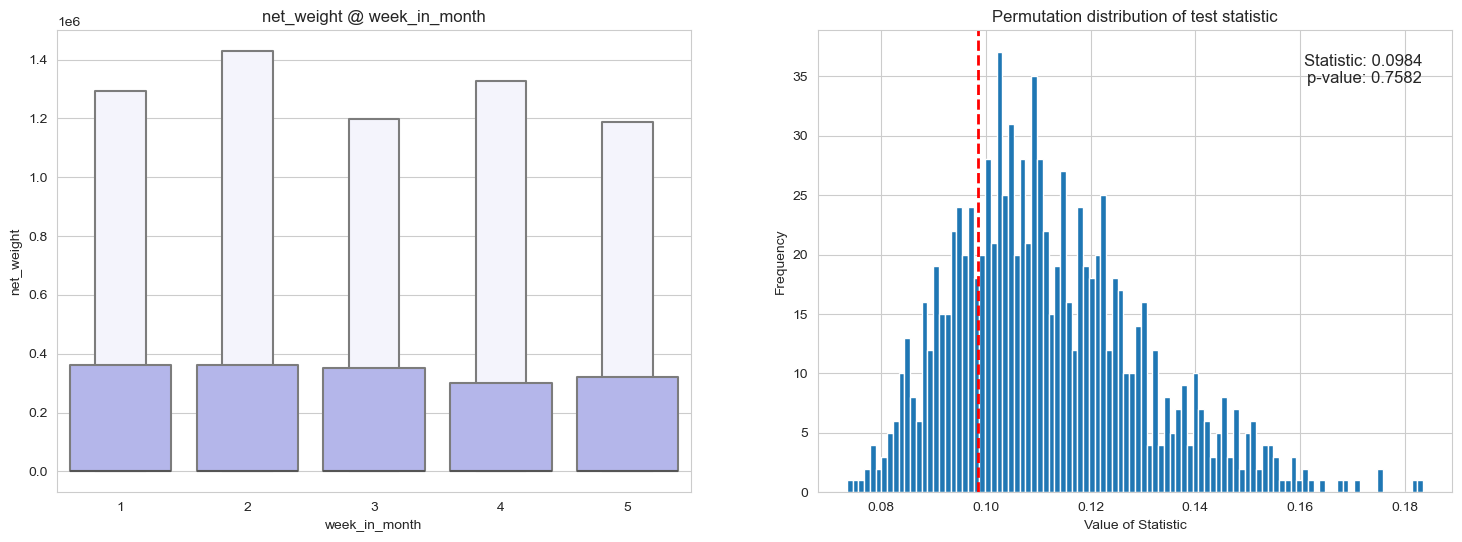

In [12]:
# Set the granularities to analyze
granularities = ['semester_in_year',
                 'quarter_in_year',
                 'month_in_year',
                 'month_in_semester',
                 'month_in_quarter',
                 'quarter_in_semester',
                 #'day_in_year',
                 #'day_in_semester',
                 #'day_in_quarter',
                 'day_in_month',
                 'day_in_week',
                 'week_in_year',
                 'week_in_semester',
                 'week_in_quarter',
                 'week_in_month']

# granularities = ['month_in_semester']

results = {}
for g in tqdm(granularities):
    res = time_granularity_analysis(cyclic_granularity=g,
                                    observations='net_weight',
                                    data=net_weight)
    res.plot()
    results.update(res.summary())

In [13]:
# Assess the significance
significance_threshold = 0.01
analysis = pd.DataFrame.from_dict(results, orient='index').reset_index()
analysis = analysis.rename(columns={'index': 'granularity'})
analysis['significant'] = analysis['pvalue'] < significance_threshold
analysis

,granularity,statistic,pvalue,significant
0,semester_in_year,0.207986,0.000999,True
1,quarter_in_year,0.453210,0.000999,True
2,month_in_year,0.538808,0.000999,True
3,month_in_semester,0.335695,0.000999,True
4,month_in_quarter,0.123259,0.000999,True
5,quarter_in_semester,0.050469,0.461538,False
6,day_in_month,0.254958,0.895105,False
7,day_in_week,0.295386,0.000999,True
8,week_in_year,0.574826,0.001998,True
9,week_in_semester,0.381105,0.036963,False


In [14]:
extraction_order = [x for x in granularity_priority if x in analysis.loc[analysis['significant']==True, 'granularity'].to_list()]
extraction_order

['week_in_year',
 'month_in_year',
 'day_in_week',
 'month_in_semester',
 'quarter_in_year',
 'month_in_quarter',
 'semester_in_year']